In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN
from sklearn.metrics import (
    pairwise_distances, adjusted_rand_score,
    silhouette_score, davies_bouldin_score
)
from sklearn.datasets import make_moons

In [2]:
def dbscan_n_clust(e, m, df):
    db = DBSCAN(eps=e, min_samples=m)
    pred = db.fit_predict(df)
    clusters_found = len(np.unique(pred))
    return clusters_found

def dbscan_score(e, m, df):
    db = DBSCAN(eps=e, min_samples=m)
    pred = db.fit_predict(df)
    score = np.nan
    # Only compute silhouette if there's more than 1 cluster
    if len(np.unique(pred)) > 1:
        score = silhouette_score(df, pred)
    return score

def entropy(cluster_assignment, y_true):
    """
    Computes a simple entropy measure of how well each true label
    is 'pure' within the predicted clusters. 
    """
    df = (
        pd.DataFrame([cluster_assignment, y_true], index=["cluster", "label"])
        .T
    )
    
    def group_entropy(s):
        e = s.value_counts(normalize=True)
        e *= np.log2(e)
        return -e.sum()
    
    group_stats = (
        df
        .groupby("label")["cluster"]
        .agg([group_entropy, "count"])
    )
    # Weighted sum of entropies
    ew = (group_stats.prod(axis=1).sum()) / len(y_true)
    return ew

In [3]:
def agg_eval(e, m, y_true, df):
    """
    Runs DBSCAN on df with (eps=e, min_samples=m),
    returns a tuple:
      (clusters_found, contains_noise, silhouette_score, ARS, davies_bouldin_score)
    """
    db = DBSCAN(eps=e, min_samples=m)
    db.fit(df)
    unique_labels = np.unique(db.labels_)
    clusters_found = len(unique_labels)
    contains_noise = (-1 in unique_labels)
    
    # True & predicted must match in shape
    y_pred = db.labels_[:len(y_true)]
    # Compute silhouette  and dbs if there's more than 1 cluster
    ss = np.nan
    dbs = np.nan
    if len(unique_labels) > 1:
        ss = silhouette_score(df, y_pred)
        dbs = davies_bouldin_score(df, y_pred)
    
    # e_ = entropy(y_pred, y_true)
    ars = adjusted_rand_score(y_true, y_pred)
    
    return clusters_found, contains_noise, ss, ars, dbs

vec_agg_eval = np.vectorize(agg_eval, excluded={2, 3})

In [4]:
def visualize_dbscan_results(df, y_true, eps=None, mins=None, marker_offset=0.1):
    """
    Visualizes DBSCAN performance across a grid of (eps, min_samples) values.
    
    Plots:
      - Scatter of df (top-left)
      - Histogram of nearest neighbor distances (top-middle)
      - Heatmaps of (#clusters, silhouette, ARS, Davies-Bouldin) in a 2x2 block
        with some markers for 'noise' cells or max scoring cells.
    
    Parameters
    ----------
    df : array-like of shape (n_samples, n_features)
        The data to cluster.
    y_true : array-like of shape (n_samples,)
        True labels for evaluating ARS, Davies-Bouldin, etc.
    eps : array-like, optional
        Range of eps values to explore. Defaults to np.arange(3, 5.5, 0.5).
    mins : array-like, optional
        Range of min_samples values to explore. Defaults to np.logspace(2, 6, 5, base=2, dtype=int).
    marker_offset : float
        Offset used when plotting the position of markers on the heatmaps.
    """
    if eps is None:
        eps = np.arange(3, 5.5, 0.5)
    if mins is None:
        mins = np.logspace(2, 6, 5, base=2, dtype=int)
    
    # Build mesh of eps, mins
    eps_grid, mins_grid = np.meshgrid(eps, mins)
    
    # Evaluate DBSCAN for all combinations
    n_clusts_, noise_, scores_, ars_, dbs_ = vec_agg_eval(
        eps_grid, mins_grid, y_true, df
    )
    
    # Create DataFrames for each metric
    eps_labels = pd.Series(eps, name="eps").round(2)
    idx_mins = pd.Series(mins, name="min_samples")
    
    n_clusts_df = pd.DataFrame(n_clusts_, index=idx_mins, columns=eps_labels)
    scores_df = pd.DataFrame(scores_, index=idx_mins, columns=eps_labels)
    ars_df = pd.DataFrame(ars_, index=idx_mins, columns=eps_labels)
    dbs_df = pd.DataFrame(dbs_, index=idx_mins, columns=eps_labels)
    
    # FIGURE LAYOUT
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
    plt.tight_layout()
    
    # -------------------------------------------------------------------
    # TOP ROW: Scatter, histogram, #clusters heatmap
    # -------------------------------------------------------------------
    # (a) Scatter of the raw data
    sns.scatterplot(x=df[:, 0], y=df[:, 1], ax=axes[0, 0])
    axes[0, 0].axis("equal")
    axes[0, 0].spines.top.set_visible(False)
    axes[0, 0].spines.right.set_visible(False)
    axes[0, 0].set_xlabel("Feature 1")
    axes[0, 0].set_ylabel("Feature 2")
    axes[0, 0].set_title("Raw Data", size="medium")
    
    # (b) Histogram of nearest-neighbor distances
    all_distances = pairwise_distances(df)
    # For each row, ignore diagonal by setting it to a large value & taking min
    all_distances_temp = all_distances.copy()
    n_ = len(all_distances_temp)
    all_distances_temp[np.diag_indices(n_)] = all_distances_temp.max() + 1e6
    neig_distances = np.min(all_distances_temp, axis=1)
    
    sns.histplot(
        neig_distances, ax=axes[0, 1], kde=True, color="steelblue",
        bins=25, binrange=(0, .25))
    
    axes[0, 1].spines.top.set_visible(False)
    axes[0, 1].spines.right.set_visible(False)
    axes[0, 1].set_xlabel("Distance to Closest Neighbor")
    axes[0, 1].set_ylabel("Count")
    axes[0, 1].set_title("NND Histogram", size="medium")
    
    # (c) Heatmap: number of clusters
    sns.heatmap(
        n_clusts_df, ax=axes[0, 2], annot=True, fmt="d", 
        cmap="Blues", cbar_kws={"location": "top", "label": "# of Clusters"}
    )
    
    # -------------------------------------------------------------------
    # BOTTOM ROW: Silhouette, ARS, Davies-Bouldin
    # -------------------------------------------------------------------
    # (d) Silhouette
    #   Range can be [-1, 1], so a diverging palette is appropriate
    sns.heatmap(
        scores_df, ax=axes[1, 0], annot=True, fmt=".2f",
        cmap="Spectral", vmin=-1, vmax=1,
        cbar_kws={"location": "top", "label": "Silhouette Score"}
    )
    
    # (e) Adjusted Rand Score
    #   Range can be [-1, 1], though typically in [-0.5, 1]
    sns.heatmap(
        ars_df, ax=axes[1, 1], annot=True, fmt=".2f",
        cmap="icefire", vmin=-0.5, vmax=1,
        cbar_kws={"location": "top", "label": "Adjusted Rand Score"}
    )
    
    # (f) Davies-Bouldin [0, 1]
    #   A sequential palette from 0 to 1
    sns.heatmap(
        dbs_df, ax=axes[1, 2], annot=True, fmt=".2f",
        cmap="flare", vmin=0,
        cbar_kws={"location": "top", "label": "Davies-Bouldin Score"}
    )
    
    # -------------------------------------------------------------------
    # HELPER FUNCTIONS to mark interesting cells
    # -------------------------------------------------------------------
    def plot_max_point(arr, ax, offset=marker_offset):
        """
        Find the cell with the maximum value in 'arr' (ignoring NaN),
        and place a 'X' marker.
        """
        max_idx = np.nanargmax(arr)
        iy, ix = np.unravel_index(max_idx, arr.shape)
        # Slight offset to place the marker
        ax.plot(ix + offset, iy + offset, "X", color="red", label="Max")
        ax.legend(
            loc="right", bbox_to_anchor=(1.05, 1.25), 
            handletextpad=0.1, frameon=False
        )

    def plot_min_point(arr, ax, offset=marker_offset):
        """
        Find the cell with the minimum value in 'arr' (ignoring NaN),
        and place a 'X' marker.
        """
        min_idx = np.nanargmin(arr)
        iy, ix = np.unravel_index(min_idx, arr.shape)
        # Slight offset to place the marker
        ax.plot(ix + offset, iy + offset, "X", color="blue", label="Min")
        ax.legend(
            loc="right", bbox_to_anchor=(1.05, 1.25), 
            handletextpad=0.1, frameon=False
        )
    
    def plot_noise_flag(noise_arr, ax, offset=marker_offset):
        """
        For any True cell in noise_arr, place a '.' marker there,
        indicating presence of noise in DBSCAN labels.
        """
        # np.where returns (row_indices, col_indices)
        rows, cols = np.where(noise_arr)
        ax.plot(cols + offset, rows + offset, ".", color="red", label="Noise")
        if len(rows) > 0:
            ax.legend(
                loc="right", bbox_to_anchor=(1.05, 1.25),
                bbox_transform=ax.transAxes,
                handletextpad=0.1, frameon=False
            )
    
    # Mark noise in the #clusters heatmap
    plot_noise_flag(noise_, axes[0, 2])
    # Mark best silhouette
    plot_max_point(scores_, axes[1, 0])
    # Mark best ARS
    plot_max_point(ars_, axes[1, 1])
    # Mark best ARS
    plot_min_point(dbs_, axes[1, 2])

    plt.subplots_adjust(hspace=.2)
    fig.suptitle("DBSACN Performance", y=1.04)


In [5]:
X, y = make_moons(n_samples=1000, noise=0.1, random_state=17)

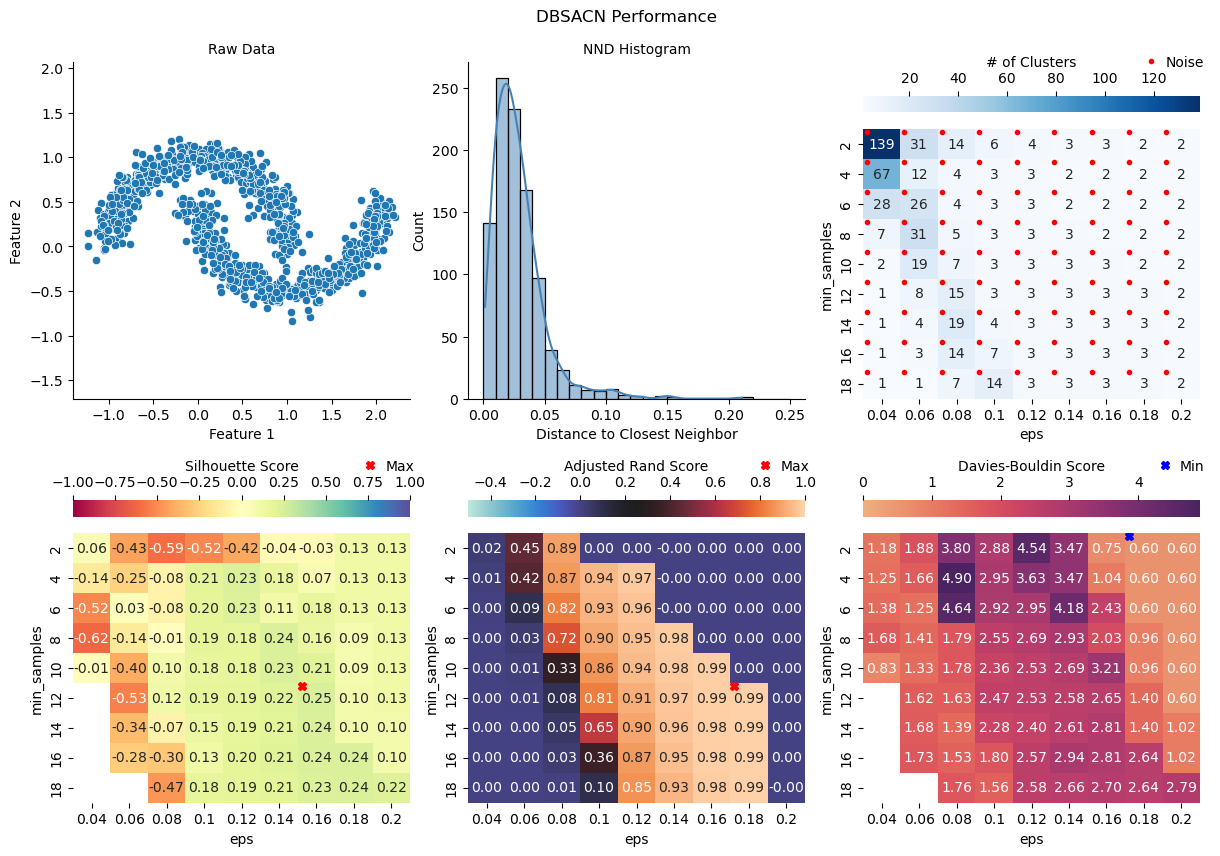

In [6]:
visualize_dbscan_results(
    X, y,
    eps=np.arange(0.04, 0.22, 0.02),
    mins=range(2, 20, 2) 
)

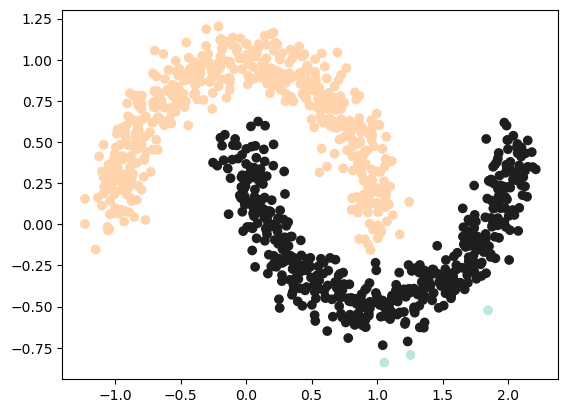

In [7]:
plt.scatter(
    X[:, 0], X[:, 1], c=DBSCAN(eps=0.18, min_samples=12).fit_predict(X), cmap="icefire"
);